In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
DATA_DIR = '../../../CarpeDiem Extubation Prediction Sam Alec/data'

## Read in O2 device report and current formatted EDW dataset

In [4]:
edw = pd.read_csv(f'{DATA_DIR}/{edw_path}')
edw['calendar_day'] = [np.datetime64(rt, 'D') for rt in edw.day_bucket_starts]
edw['patient_calendar_day'] = [str(r.pt_study_id) + str(r.calendar_day) for i,r in edw.iterrows()]

In [5]:
binary_map = {1:'intubated',0:'extubated'}
edw['extubation_status'] = edw['Intubation_flag'].map(binary_map)

In [7]:
o2 = pd.read_csv(f'{o2_path}')
o2['RECORDED_TIME'] = pd.to_datetime(o2['RECORDED_TIME'])
o2['calendar_day'] = [np.datetime64(rt, 'D') for rt in o2.RECORDED_TIME]
o2['patient_calendar_day'] = [str(r.pt_study_id) + str(r.calendar_day) for i,r in o2.iterrows()]
o2['time_of_day'] = [x.astype('datetime64[s]').astype(object).time() for x in o2.RECORDED_TIME.values]

In [8]:
calendar_day_map = {
    r.patient_calendar_day:r.patient_day for i,r in edw.iterrows()
}
o2['patient_day'] = o2['patient_calendar_day'].map(calendar_day_map)

In [9]:
new_status_dict = {
    r.patient_day:r.extubation_status for i,r in edw.iterrows()
}
o2['extubation_status'] = o2['patient_day'].map(new_status_dict)

In [10]:
edw[['Intubation_flag','extubation_status']].value_counts()

Intubation_flag  extubation_status
1                intubated            11564
0                extubated             4841
Name: count, dtype: int64

## Check for intubated days that are mis-annotated
Check for extubation events on intubated days

In [12]:
def check_extubation(sub):
    extub_yes = ((sub.DISP_NAME == "Extubation") & (sub.MEAS_VALUE == "Yes"))
    vent_dc = ((sub.DISP_NAME == 'Vent D/C') | (sub.DISP_NAME == 'Vent D/C Time'))

    return np.any(extub_yes | vent_dc)

In [13]:
flag_extub = []
intub_days = edw[edw.Intubation_flag == 1].patient_calendar_day.unique()
for day in intub_days:
    sub = o2[
        (o2.patient_calendar_day == day) & (o2['time_of_day'] < datetime.time(8, 0))
    ]
    if check_extubation(sub):
        flag_extub.append(day)

In [14]:
len(flag_extub)

4

Check

In [15]:
# o2[o2.patient_calendar_day == flag_extub[3]]

In [16]:
edw.loc[edw.patient_calendar_day.isin(flag_extub),'extubation_status'] = 'early extubation'

In [17]:
o2.loc[o2.patient_calendar_day.isin(flag_extub),'extubation_status'] = 'early extubation'

## Check for extubated days that are mis-annotated

In [18]:
# either all ventilation, or at least three signs of ventilation
def check_intubation(sub):
    # keep simple
    if len(sub) > 0:
        vent_display = ((sub.DISP_NAME == 'O2 Device') & (sub.MEAS_VALUE == 'Ventilator'))
        vent_yes = (sub.DISP_NAME == 'Ventilator')
        if np.all(vent_display | vent_yes):
            return True
        else:
            cts = np.where(vent_display | vent_yes)[0]
            return len(cts) >= 3

In [19]:
flag_intub = []
extub_days = edw[edw.Intubation_flag == 0].patient_calendar_day.unique()
for day in extub_days:
    sub = o2[
        (o2.patient_calendar_day == day) & (o2['time_of_day'] < datetime.time(8, 0))
    ]
    if check_intubation(sub):
        flag_intub.append(day)

In [20]:
len(flag_intub)

1079

In [21]:
# o2[o2.patient_calendar_day == flag_intub[345]]

These should all be intubated

In [22]:
edw.loc[edw.patient_calendar_day.isin(flag_intub),'extubation_status'] = 'intubated'
o2.loc[o2.patient_calendar_day.isin(flag_intub),'extubation_status'] = 'intubated'

In [23]:
edw[['extubation_status','Intubation_flag']].value_counts()

extubation_status  Intubation_flag
intubated          1                  11560
extubated          0                   3762
intubated          0                   1079
early extubation   1                      4
dtype: int64

In [24]:
edw['Intubation_flag'] = [1 if x == 'intubated' else 0 for x in edw.extubation_status]

## Label fail if reintubated within two days

In [26]:
def first_intubation_date(x):
    r = x.loc[x.Intubation_flag.eq(1)].head(1)
    if r.shape[0]:
        return r.day_bucket_starts.values[0]
    return np.nan

In [49]:
first_intub_by_pt_stay = edw.groupby(['pt_study_id', 'stay']).apply(first_intubation_date)

In [50]:
THRESHOLD = 2
for k, df_slice in edw.groupby(['pt_study_id', 'stay']):
    intub = False
    prev_slice = None
    for _, intub_slice in df_slice.groupby(
        (df_slice.Intubation_flag.shift() != df_slice.Intubation_flag).cumsum()
    ):
        intub_flag = intub_slice.Intubation_flag.values[0] == 1
        if intub_flag:
            # df.loc[intub_slice.index, 'extubation_status'] = 'intubated'
            if intub and prev_slice is not None and prev_slice.shape[0] <= THRESHOLD:
                edw.loc[prev_slice.index, 'extubation_status'] = 'failed'
            intub = True
        else:
            if intub:
                # check next stay intubation date against the current
                cur_pt = df_slice.pt_study_id.values[0]
                cur_stay = df_slice.stay.values[0]
                cur_date = pd.to_datetime(intub_slice.day_bucket_starts).values[0]
                next_stay_key = (cur_pt, cur_stay + 1)
                if next_stay_key in first_intub_by_pt_stay.index:
                    next_intub_date = pd.to_datetime(first_intub_by_pt_stay[next_stay_key])
                    delta = (next_intub_date - cur_date).days
                    if delta <= THRESHOLD:
                        edw.loc[intub_slice.index, 'extubation_status'] = 'failed'
                    else:
                        pass
                        # df.loc[intub_slice.index, 'extubation_status'] = 'successful'
                else:
                    pass
                    # df.loc[intub_slice.index, 'extubation_status'] = 'successful'
            else:
                pass
                # df.loc[intub_slice.index, 'extubation_status'] = 'preintubation'
        prev_slice = intub_slice

In [51]:
edw.extubation_status.value_counts()

intubated           12639
extubated            3629
failed                133
early extubation        4
Name: extubation_status, dtype: int64

In [52]:
fails = edw[edw.extubation_status == 'failed'].patient_day.values

In [53]:
def examine_fail(day):
    num_day = day.rsplit('/',1)[1]
    start_str = day.rsplit('/',1)[0]
    trail_day = f"{start_str}/{int(num_day)+1}"
    trail_day_2 = f"{start_str}/{int(num_day)+2}"
    lead_day = f"{start_str}/{int(num_day)-1}"
    return df[df.patient_day.isin([lead_day,day,trail_day,trail_day_2])][['Intubation_flag','extubation_status']]

In [55]:
# examine_fail(fails[2])

These look good to go

In [56]:
o2.loc[o2.patient_day.isin(edw[edw.extubation_status == 'fail'].patient_day),'extubation_status'] = 'fail'

## Label CMO

In [12]:
endpoints = pd.read_csv(
    endpoints_path,
    encoding="unicode_escape"
)

In [13]:
edw = edw.merge(
    endpoints[['pt_study_id','death_date','discharge_disposition_name']],
    on='pt_study_id',
    how='left'
)

In [59]:
edw.discharge_disposition_name.value_counts(dropna=False)

Expired                                                          6858
Acute Inpatient Rehabilitation                                   3382
Long-Term Acute Care Hospital (LTAC)                             3061
Home with Home Health Care                                        934
Skilled Nursing Facility or Subacute Rehab Care                   655
Home or Self Care                                                 522
NaN                                                               498
Home with Hospice                                                 167
Inpatient Hospice                                                 142
Home with Outpatient Services                                      79
Against Medical Advice (AMA) or Elopement                          39
Acute Care Hospital                                                24
Home with Equipment or O2                                          21
Planned Readmission  DC/transferred to acute inpatient rehab      12
Group Home          

In [60]:
edw.drop_duplicates(subset='pt_study_id').death_date.isnull().value_counts(dropna=False)

True     363
False    349
Name: death_date, dtype: int64

In [61]:
renames = {
    "Home with Home Health Care": "Home", 
    "Home or Self Care": "Home",
    "Against Medical Advice (AMA) or Elopement": "Home", 
    "Group Home": "Home", 
    "Home with Equipment or O2": "Home", 
    "Home with Outpatient Services": "Home", 
    "Inpatient Psychiatric Hospital": "Home",
        
    "Acute Inpatient Rehab": "Rehab",
    "Planned Readmission – DC/transferred to acute inpatient rehab": "Rehab",
    "Acute Inpatient Rehabilitation": "Rehab",
    
    "Skilled Nursing Facility or Subacute Rehab Care":"SNF",
    
    "Acute Care Hospital": "LTACH", 
    "Long-Term Acute Care Hospital (LTAC)": "LTACH", 
     
    "Home with Hospice": "Hospice", 
    "Inpatient Hospice": "Hospice", 

    "Expired": "Died"
}

edw.discharge_disposition_name.replace(renames, inplace=True)
edw["binary_outcome"] = "Alive"
edw.loc[df.discharge_disposition_name.isin(["Hospice", "Died"]), "binary_outcome"] = "Died"

### Recode lung transplant outcome as death

In [15]:
trans = pd.read_csv(trans_path,encoding='unicode_escape')

In [63]:
trans = trans[trans.lung_transplant_date.notnull()]

In [64]:
trans.lung_transplant_date = pd.to_datetime(trans.lung_transplant_date.values)

In [65]:
flag_transplants = []
for i,r in trans.iterrows():
    trans_date = r.lung_transplant_date
    first_date = edw[edw.pt_study_id == r.pt_study_id].calendar_day.min()
    last_date = edw[edw.pt_study_id == r.pt_study_id].calendar_day.max()
    if trans_date >= first_date and trans_date <= last_date:
        flag_transplants.append(r.pt_study_id)

In [66]:
len(flag_transplants)

11

For each day after transplant, mark these as transplanted. I will treat these as dni because the lungs "died".

In [69]:
for t in flag_transplants:
    trans_date = trans[trans.pt_study_id == t].lung_transplant_date.values[0]
    sub = edw[edw.pt_study_id == t]
    flag_index = sub[sub.calendar_day == trans_date].index.values[0]
    edw.loc[flag_index:sub.index.values[-1],'extubation_status'] = 'dni transplant'

In [78]:
edw.extubation_status.value_counts()

intubated           12375
extubated            3537
dni transplant        362
failed                127
early extubation        4
Name: extubation_status, dtype: int64

In [86]:
edw.drop_duplicates(subset='pt_study_id').binary_outcome.value_counts(dropna=False)

Alive    404
Died     308
Name: binary_outcome, dtype: int64

### Use redcap known CMO and backtrack leading extubated days

In [87]:
eos = pd.read_csv(eos_path)

In [88]:
dni_pts = list(eos.loc[eos.withdraw_lst.eq(1) & eos.withdrawn_lst.str.contains('Invasive mechanical'),'pt_study_id'])

In [92]:
df = edw.set_index('patient_day')

In [93]:
last_days = df.groupby(['pt_study_id']).tail(1)
last_dni_days = last_days[(last_days.Intubation_flag == False) & (last_days.pt_study_id.isin(dni_pts))]
for i, r in last_dni_days.iterrows(): # i is index, r is all row data
    pt_day = r.day
    while True: # set up while loop that will be broken if we know we've gone beyond possible CMO
        i = f"{r.pt_study_id}/{r.stay}/{pt_day}"
        if pt_day < 1 or df.Intubation_flag[i] == 1:
            break
        df.loc[i, 'extubation_status'] = 'dni'
        pt_day -= 1

In [94]:
df.extubation_status.value_counts(dropna=False)

intubated           12375
extubated            3428
dni transplant        362
failed                127
dni                   109
early extubation        4
Name: extubation_status, dtype: int64

### If extubated within two days of death, then labels as dni (show histogram)

In [95]:
def first_day_last_extub_fun(x):
    last = x.iloc[-1, :]
    if last.extubation_status != 'extubated' or last.pt_study_id in dni_pts: # not successful or already dni
        return
    # find first row of last stretch of extubation
    i = None
    for idx in reversed(x.index):
        if x.loc[idx].Intubation_flag == 1:
            break
        i = idx
    return x.loc[i]
    
first_day_last_extub = df.groupby(['pt_study_id']).apply(first_day_last_extub_fun)

In [96]:
first_day_last_extub = first_day_last_extub[first_day_last_extub.pt_study_id.notnull()]
first_day_last_extub.stay = first_day_last_extub.stay.astype(int)
first_day_last_extub.day = first_day_last_extub.day.astype(int)
first_day_last_extub.index = (
    first_day_last_extub.pt_study_id.astype(int).astype(str)
    + '/' + first_day_last_extub.stay.astype(int).astype(str)
    + '/' + first_day_last_extub.day.astype(int).astype(str)
)

first_day_last_extub['death_date'] = pd.to_datetime(
    df.death_date[first_day_last_extub.index]
)
first_day_last_extub['day_bucket_starts'] = pd.to_datetime(
    df.day_bucket_starts[first_day_last_extub.index]
)
first_day_last_extub['time_to_death'] = (
    first_day_last_extub.death_date - first_day_last_extub.day_bucket_starts
).dt.days

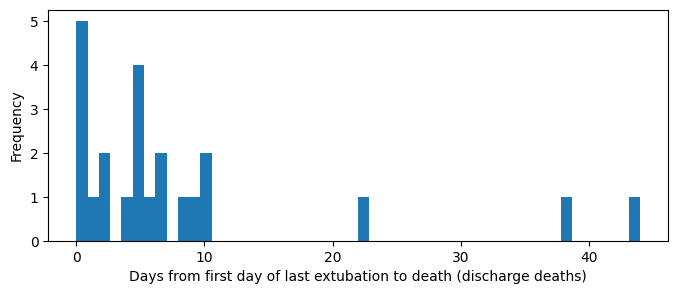

In [97]:
fig, ax = plt.subplots(figsize=(8, 3))
discharge_deaths = first_day_last_extub[first_day_last_extub.discharge_disposition_name == 'Died']
discharge_deaths.time_to_death.plot.hist(bins=50,ax=ax)
ax.set_xlabel('Days from first day of last extubation to death (discharge deaths)')
plt.show()

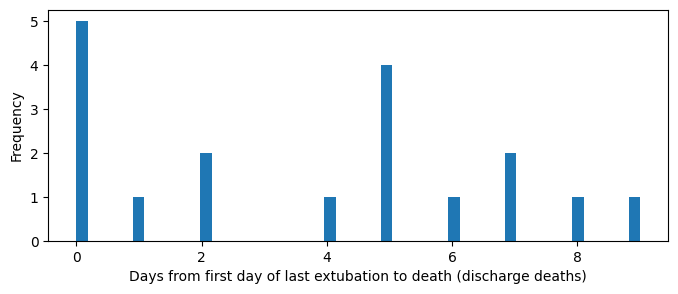

In [98]:
fig, ax = plt.subplots(figsize=(8, 3))
discharge_deaths = first_day_last_extub[first_day_last_extub.discharge_disposition_name == 'Died']
discharge_deaths[discharge_deaths.time_to_death < 10].time_to_death.plot.hist(bins=50,ax=ax)
ax.set_xlabel('Days from first day of last extubation to death (discharge deaths)')
plt.show()

If within two days, flag as CMO

In [99]:
non_dni_early_deaths = first_day_last_extub.loc[
    first_day_last_extub.time_to_death.le(THRESHOLD)
]

In [100]:
for i, r in non_dni_early_deaths.iterrows():
    pt_day = r.day
    while True:
        i = f"{int(r.pt_study_id)}/{int(r.stay)}/{int(pt_day)}"
        if pt_day > df[df.pt_study_id == r.pt_study_id].day.max() or df.Intubation_flag[i] == 1:
            break
        df.loc[i, 'extubation_status'] = 'suspected dni'
        pt_day += 1

In [101]:
df.extubation_status.value_counts(dropna=False)

intubated           12375
extubated            3415
dni transplant        362
failed                127
dni                   109
suspected dni          13
early extubation        4
Name: extubation_status, dtype: int64

## Save checks

In [102]:
edw.extubation_status = df.extubation_status.values

In [103]:
edw[['extubation_status','Intubation_flag']].value_counts()

extubation_status  Intubation_flag
intubated          1                  12375
extubated          0                   3415
dni transplant     1                    264
failed             0                    127
dni                0                    109
dni transplant     0                     98
suspected dni      0                     13
early extubation   0                      4
dtype: int64

Death info should be on edw df

In [104]:
for col in df.columns:
    if col not in edw.columns:
        edw[col] = df[col].values

### Check for withdrawn patients

In [123]:
# for p in [****,****,****]:
#     if p in list(edw.pt_study_id.unique()):
#         print(p)

Not in here

## Remove flagged ECMO/extubation days

- think most of this is by default filtered because extubated, but double check

In [108]:
mapper = pd.read_csv(mapper_path)

In [109]:
mapper_dict = {}
for c in mapper.patient.unique():
    sub = mapper[mapper.patient == c]
    if len(sub) > 0:
        mapper_dict[c] = sub.Patient_id.values[0]

In [110]:
edw['old_id'] = edw.pt_study_id.map(mapper_dict)

In [111]:
edw['old_Patient_id_2'] = [str(int(r.old_id))+'/'+str(int(r.stay)) if not pd.isna(r.old_id) else None for i,r in edw.iterrows()]

Manually change extubation status of a handful of patient days that were flagged from chart review, save intermediate file

In [120]:
# edw.to_csv()

In [121]:
new_status_dict = {
    r.patient_day:r.extubation_status for i,r in edw.iterrows()
}
o2['extubation_status'] = o2['patient_day'].map(new_status_dict)

In [122]:
# o2.to_csv()